In [287]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
plt.style.use('default')

In [288]:
# matlotib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.size'] = 13
plt.rcParams['xtick.minor.size'] = 5

# Measuring GM Tube Plateau Curve to find operating voltage

In [289]:
# Importing the dataset
data_plateau = np.loadtxt('../data/RadiationLabPlateau.tsv', delimiter='\t', usecols=(0,1, 2), skiprows=11).T

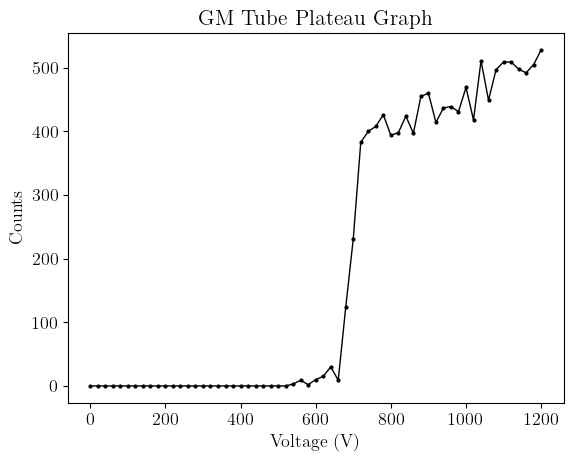

In [290]:
plt.plot(data_plateau[1], data_plateau[2], "o-", lw=1, ms=2, label="data", color="black")
plt.xlabel("Voltage (V)")
plt.ylabel("Counts")
plt.title("GM Tube Plateau Graph")
plt.savefig("../figures/PlateauGraph.png", dpi = 300)

We decided to use 900 V as the operating voltage for the GM tube since it in the middle of the plateau curve before the tube starts to saturate.

# Measuring the background count rate

In [291]:
data_background = np.loadtxt('../data/BackgroundCountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T

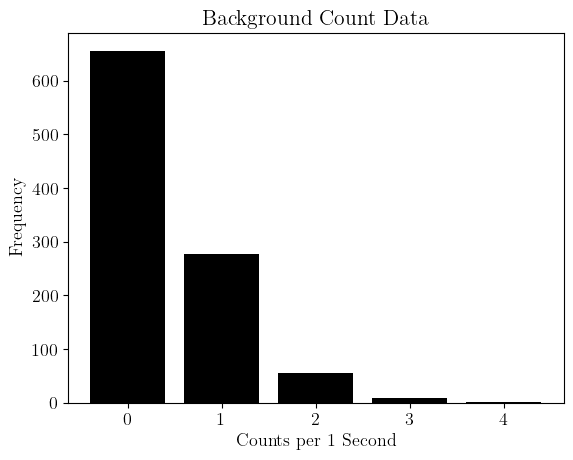

In [292]:
labels, counts = np.unique(data_background[2], return_counts=True)
plt.bar(labels, counts, align='center', color="black")
plt.gca().set_xticks(labels)
plt.xlabel("Counts per 1 Second")
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../figures/BackgroundCountHist1sec.png", dpi=300)

In [293]:
data_background_10 = np.array([np.sum(data_background[2][10*i:10*(i+1)]) for i in range(100)])

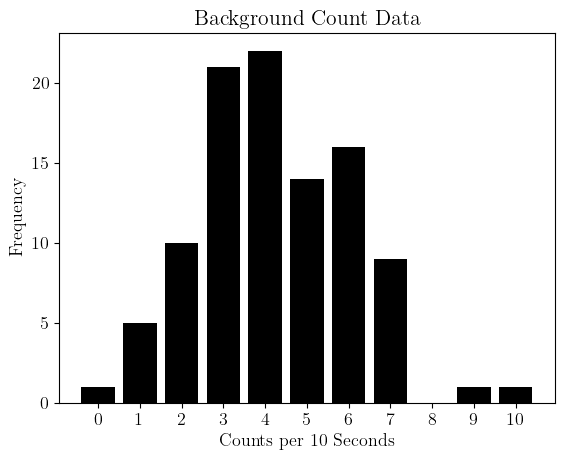

In [294]:
labels, counts = np.unique(data_background_10, return_counts=True)
plt.bar(labels, counts, align='center', color="black")
plt.gca().set_xticks(range(11))
plt.xlabel("Counts per 10 Seconds")
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../figures/BackgroundCountHist10sec.png", dpi = 300)

In [295]:
data_background_100 = np.array([np.sum(data_background[2][100*i:100*(i+1)]) for i in range(10)])
data_background_100

array([48., 44., 37., 32., 51., 37., 39., 42., 48., 46.])

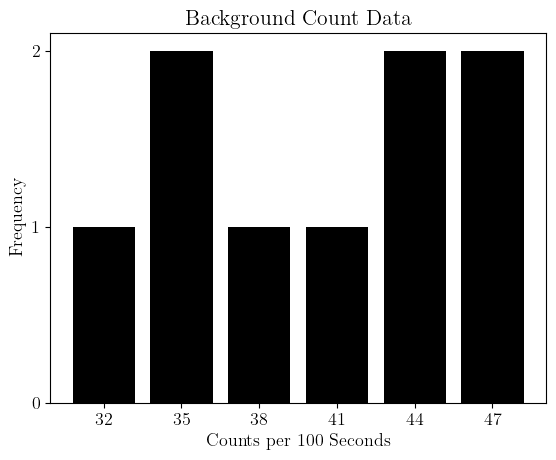

In [296]:
plt.hist(data_background_100, bins = range(32, 53, 3), align="left", rwidth=0.8, color="black")
plt.xlabel("Counts per 100 Seconds")
plt.xticks(range(32, 50, 3))
plt.yticks(range(0, 3))
plt.ylabel("Frequency")
plt.title("Background Count Data")
plt.savefig("../figures/BackgroundCountHist100sec.png", dpi = 300)

# Finding the count rate of the background, Cs137, Co60, and combined sources

In [297]:
# loading in the data
data_cs137 = np.loadtxt('../data/Cs137CountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
data_co60 = np.loadtxt('../data/Co60CountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
data_combined = np.loadtxt('../data/TwoSourceCountData.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T

In [298]:
background_counts = data_background_100.sum()
cs137_counts = data_cs137[2].sum()
co60_counts = data_co60[2].sum()
combined_counts = data_combined[2].sum()

In [299]:
def get_count_rate_std(counts, backround_counts, period):
    std = np.sqrt(counts + backround_counts)/period
    return counts/period, std

In [300]:
background_rate, background_rate_std = get_count_rate_std(background_counts, 0, 1000)
display(Latex(f"Reported Background Count Rate: ${background_rate} \pm {background_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

Measuring the count rate of Cs137

In [301]:
cs137_rate, cs137_rate_std = get_count_rate_std(cs137_counts, background_counts, 1000)
display(Latex((f"Reported Cs137 Count Rate: ${cs137_rate} \pm {cs137_rate_std}$ counts per second")))

<IPython.core.display.Latex object>

Measuring the count rate of Co60

In [302]:
co60_rate, co60_rate_std = get_count_rate_std(co60_counts, background_counts, 1000)
display(Latex(f"Reported Co60 Count Rate: ${co60_rate} \pm {co60_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

Measuring the combined count rates of Cs137 and Co60

In [303]:
combined_rate, combined_rate_std = get_count_rate_std(combined_counts, background_counts, 1000)
display(Latex(f"Reported Combined Count Rate: ${combined_rate} \pm {combined_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

Combined is likely less due to the Co60 source being further away from the GM tube compared to the Cs137 source.

# Calculating the Deadtime of the GM Tube
To calculate the deadtime of the GM tube, the following equation was used:
$$T = \frac{r_{1} + r_{2} - r_{12}}{2 r_{1} r_{2}}$$
where $r_{1}$ is the count rate of the Cs137, $r_{2}$ is the count rate of the Co60, and $r_{12}$ is the count rate of the combined sources.

In [304]:
import sympy as sp

In [305]:
def arbitruary_std(sympy_expression, vars, stds, vars_values, stds_values):
    n_func = sp.lambdify(vars, sympy_expression)
    std = sp.sqrt(np.array([sp.diff(sympy_expression, var)**2 * mean_std**2 for var, mean_std in zip(vars, stds)]).sum())
    n_mean_std_func = sp.lambdify(vars+stds, std)
    return n_func(*vars_values), n_mean_std_func(*vars_values, *stds_values)

In [306]:
# Define variables
r_1, r_2, r_12, S_1, S_2, S_3 = sp.symbols("r_1 r_2 r_12 S_1 S_2 S_3", real=True, positive=True)

In [307]:
# Define deadtime expression
T = (r_1 + r_2 - r_12)/(2*r_1*r_2)
T

(r_1 - r_12 + r_2)/(2*r_1*r_2)

In [308]:
deadtime, deadtime_std = arbitruary_std(T, [r_1, r_2, r_12], [S_1, S_2, S_3], [cs137_rate, co60_rate, combined_rate], [cs137_rate_std, co60_rate_std, combined_rate_std])
display(Latex(f"Deadtime: {deadtime} +/- {deadtime_std}")) # Calculate the deadtime

<IPython.core.display.Latex object>

Assuming a Poisson distribution, the following equation was used to calculate the true count rate of the sources:
$$R = \frac{r}{1 - rT}$$
where $r$ is the measured count rate and $T$ is the deadtime.

In [309]:
r, T, S_r, S_T = sp.symbols("r T S_r S_T", real=True, positive=True)

In [310]:
R = r/(1 - r*T)

In [311]:
# Calculate the true count rate
true_cs137_rate, true_cs137_mean_std = arbitruary_std(R, [r, T], [S_r, S_T], [cs137_rate, deadtime], [cs137_rate_std, deadtime_std])
true_co60_rate, true_co60_mean_std = arbitruary_std(R, [r, T], [S_r, S_T], [co60_rate, deadtime], [co60_rate, deadtime_std])
display(Latex(f"True Cs137 Count Rate: ${true_cs137_rate} \pm {true_cs137_mean_std}$"))
display(Latex(f"True Co60 Count Rate: ${true_co60_rate} \pm {true_co60_mean_std}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Shielding Experiment
Co60:
0: Unshielded
1: Lead, 6.35 mm
2: Lead, 3.175 mm
3: Lead, 1.6256 mm
4: Lead, 0.8128 mm

In [312]:
# load data
data_co60_0 = np.loadtxt('../data/Co60Unshielded.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
data_co60_1 = np.loadtxt('../data/Co60_1_625mm.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
data_co60_2 = np.loadtxt('../data/Co60_3_175mm.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
data_co60_3 = np.loadtxt('../data/Co60_6_35mm.tsv', delimiter='\t', skiprows=11, usecols=(0,1, 2)).T
period = 300*5 # 25 minute runs

In [313]:
co60_0_counts = data_co60_0[2].sum()
co60_0_counts_std = np.sqrt(co60_0_counts)
display(Latex(f"Unshielded Co60 Counts: ${co60_0_counts} \pm {co60_0_counts_std}$"))

<IPython.core.display.Latex object>

In [314]:
co60_0_count_rate, co60_0_count_rate_std = get_count_rate_std(co60_0_counts, background_rate*period, period)
display(Latex(f"Unshielded Co60 Count Rate: ${co60_0_count_rate} \pm {co60_0_count_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

In [315]:
# Shielded 1: Lead, 6.35 mm
co60_1_counts = data_co60_1[2].sum()
co60_1_counts_std = np.sqrt(co60_1_counts)
display(Latex(f"Shielded 1 Co60 Counts: ${co60_1_counts} \pm {co60_1_counts_std}$"))

<IPython.core.display.Latex object>

In [316]:
co60_1_count_rate, co60_1_count_rate_std = get_count_rate_std(co60_1_counts, background_rate*period, period)
display(Latex(f"Shielded 1 Co60 Count Rate: ${co60_1_count_rate} \pm {co60_1_count_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

In [317]:
# Shielded 2: Lead, 3.175 mm
co60_2_counts = data_co60_2[2].sum()
co60_2_counts_std = np.sqrt(co60_2_counts)
display(Latex(f"Shielded 2 Co60 Counts: ${co60_2_counts} \pm {co60_2_counts_std}$"))

<IPython.core.display.Latex object>

In [318]:
co60_2_count_rate, co60_2_count_rate_std = get_count_rate_std(co60_2_counts, background_rate*period, period)
display(Latex(f"Shielded 2 Co60 Count Rate: ${co60_2_count_rate} \pm {co60_2_count_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

In [319]:
# Shielded 3: Lead, 1.625 mm
co60_3_counts = data_co60_3[2].sum()
co60_3_counts_std = np.sqrt(co60_3_counts)
display(Latex(f"Shielded 3 Co60 Counts: ${co60_3_counts} \pm {co60_3_counts_std}$"))

<IPython.core.display.Latex object>

In [320]:
co60_3_count_rate, co60_3_count_rate_std = get_count_rate_std(co60_3_counts, background_rate*period, period)
display(Latex(f"Shielded 3 Co60 Count Rate: ${co60_3_count_rate} \pm {co60_3_count_rate_std}$ counts per second"))

<IPython.core.display.Latex object>

# Calculating Attenuation Coeffecient for Co60 by Taking the Mean of the Shielded Data
The equation for describing the attenuation of radiation is:
$$N/N_0 = e^{-d/d_0}$$
where $N$ is the number of counts, $N_0$ is the number of counts at the source, $d$ is the distance from the source, and $d_0$ is the attenuation coeffecient.

In [321]:
d, N, N_0, S_d, S_N, S_N_0 = sp.symbols('d N N_0 S_d, S_N, S_N_0')

In [322]:
d_0 = d/sp.ln(N_0/N)
d_0

d/log(N_0/N)

In [323]:
# experimental values of d_0
d_0_1_mean, d_0_1_mean_std = arbitruary_std(d_0, [N, N_0, d], [S_N, S_N_0, S_d], [co60_1_counts, co60_0_counts, 6.35], [co60_1_counts_std, co60_0_counts, 0])
d_0_2_mean, d_0_2_mean_std = arbitruary_std(d_0, [N, N_0, d], [S_N, S_N_0, S_d], [co60_2_counts, co60_0_counts, 3.175], [co60_2_counts_std, co60_0_counts, 0])
d_0_3_mean, d_0_3_mean_std = arbitruary_std(d_0, [N, N_0, d], [S_N, S_N_0, S_d], [co60_3_counts, co60_0_counts, 1.6256], [co60_3_counts_std, co60_0_counts, 0])
d_0_mean = np.mean([d_0_1_mean, d_0_2_mean, d_0_3_mean])
d_0_mean_std = np.sqrt(d_0_1_mean_std**2 + d_0_2_mean_std**2 + d_0_3_mean_std**2)/3
display(Latex(f"Mean Attenuation Coeffecient for Co60: ${d_0_mean} \pm {d_0_mean_std}$ mm"))

<IPython.core.display.Latex object>

# Calculating Attenuation Coeffecient for Cs137 by Fitting the Data

In [324]:
d_arr = np.array([0, 1.6256, 3.175, 6.35])
co60_count_arr = np.array([co60_0_counts, co60_1_counts, co60_2_counts, co60_3_counts])
co60_count_std_arr = np.array([co60_0_counts_std, co60_1_counts_std, co60_2_counts_std, co60_3_counts_std])
co60_count_rate_arr = np.array([co60_0_count_rate, co60_1_count_rate, co60_2_count_rate, co60_3_count_rate])
co60_count_rate_std_arr = np.array([co60_0_count_rate_std, co60_1_count_rate_std, co60_2_count_rate_std, co60_3_count_rate_std])

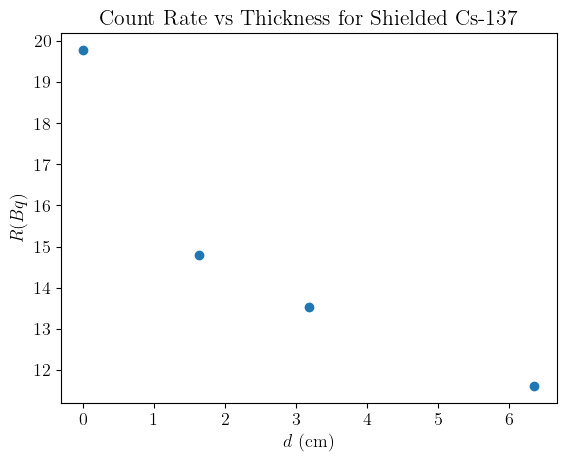

In [325]:
plt.plot(d_arr, co60_count_rate_arr, 'o')
plt.xlabel('$d$ (cm)')
plt.ylabel('$R (Bq)$')
plt.title('Count Rate vs Thickness for Shielded Cs-137')
plt.savefig('../figures/co60_rate_vs_thickness.png', dpi=300)

In [326]:
# fitting the data
from scipy.optimize import curve_fit
fit_func = lambda x, a, b: a*np.exp(-x/b)
popt, pcov = curve_fit(fit_func, d_arr, co60_count_rate_arr, p0=(1, 5))
d_0_fit = popt[1]
R_0_fit = popt[0]
d_0_fit_std = 1/np.sqrt(pcov[0,0])
R_0_fit_std = 1/np.sqrt(pcov[1,1])
display(Latex(f"Attenuation Coeffecient for Cs137: ${d_0_fit} \pm {d_0_fit_std}$ cm"))
display(Latex(f"Unshielded Rate for Cs137: ${R_0_fit} \pm {R_0_fit_std}$ counts per second"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

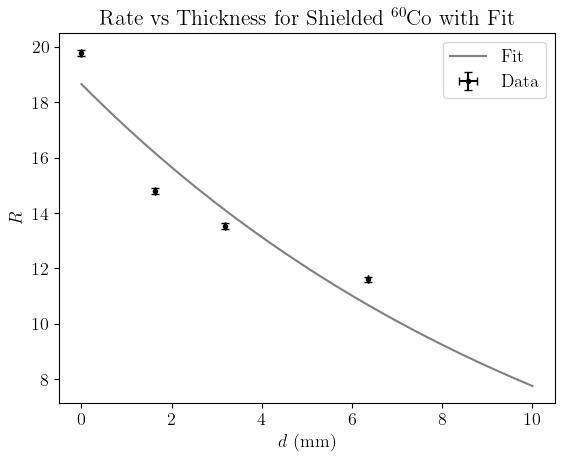

In [328]:
# plotting the fit
d_fit = np.linspace(0, 10, 1000)
plt.plot(d_fit, fit_func(d_fit, *popt), label='Fit', color = "grey")
plt.errorbar(d_arr, co60_count_rate_arr, xerr = 0, yerr = co60_count_rate_std_arr, fmt='o', label='Data', capsize=3, ms = 3, color = 'black')
plt.xlabel('$d$ (mm)')
plt.ylabel('$R$')
plt.title('Rate vs Thickness for Shielded $^{60}$Co with Fit')
plt.legend()
plt.savefig('../figures/co60_rate_vs_thickness_fit.png', dpi=300)

# Theoretical Attenuation Coeffecient for Cs137

With an C60 emitting 1.17 Mev and 1.333, we are using the mass-attenuation of 1.25 Mev for comparison.
$$\rho = 11.35 \frac{g}{cm^3}$$

In [329]:
rho = 11.35
u_m = 5.876E-02
d_0_theo = (1/(u_m*rho))*10
display(Latex(f"Theoretical Attenuation Coeffecient for Cs137: ${d_0_theo}$ mm"))

<IPython.core.display.Latex object>

# Comparing the Attenuation Coeffecients

In [330]:
display(Latex(f"Mean Attenuation Coeffecient for Co60: ${d_0_mean} \pm {d_0_mean_std}$ mm"))
display(Latex(f"Attenuation Coeffecient for Cs137: ${d_0_fit} \pm {d_0_fit_std}$ mm"))
display(Latex(f"Theoretical Attenuation Coeffecient for Cs137: ${d_0_theo}$ mm"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Comparing the Attenuation Coeffecients

In [331]:
display(Latex(f"Mean Attenuation Coeffecient for Co60: ${d_0_mean} \pm {d_0_mean_std}$ mm"))
display(Latex(f"Attenuation Coeffecient for Cs137: ${d_0_fit} \pm {d_0_fit_std}$ mm"))
display(Latex(f"Theoretical Attenuation Coeffecient for Cs137: ${d_0_theo}$ mm"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Tables

In [332]:
import pandas as pd
# table of d, total counts, total counts std, count rate, count rate std
shielding_df = pd.DataFrame({'d (mm)': d_arr, 'Total Counts': co60_count_arr, 'Total Counts Std.': co60_count_std_arr, 'Count Rate (Bq)': co60_count_rate_arr, 'Count Rate Std. (Bq)': co60_count_rate_std_arr})
shielding_df

,d (mm),Total Counts,Total Counts Std.,Count Rate (Bq),Count Rate Std. (Bq)
0,0.0000,29669.0,172.246916,19.779333,0.116056
1,1.6256,22194.0,148.976508,14.796000,0.100731
2,3.1750,20293.0,142.453501,13.528667,0.096446
3,6.3500,17420.0,131.984848,11.613333,0.089582


In [333]:
# export to latex
# shielding_df.to_latex('../tables/co60_shielding.tex', index=False, escape=False, column_format='ccccc')

/tmp/ipykernel_18343/3005407437.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  shielding_df.to_latex('../tables/co60_shielding.tex', index=False, escape=False)
